In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
train_dataset = pd.read_csv("./save_reduced_bert/train.csv")
test_dataset = pd.read_csv("./save_reduced_bert/test.csv")
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

train_dataset['list'] = train_dataset.iloc[:,1:].values.astype(int).tolist()
test_dataset['list'] = test_dataset.iloc[:,1:].values.astype(int).tolist()

train_dataset = train_dataset[['news', 'list']].rename(columns={"news": "comment_text"})
test_dataset = test_dataset[['news', 'list']].rename(columns={"news": "comment_text"})

TRAIN Dataset: (5956, 6)
TEST Dataset: (1489, 6)


<AxesSubplot:ylabel='Frequency'>

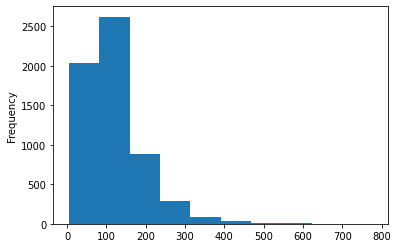

In [4]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset.comment_text.str.split().str.len().plot.hist()

In [5]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True  #####   TODO
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [6]:
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [7]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# Creating the Neural Network for Fine Tuning

In [8]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 5)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [9]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

# Fine Tuning the Model

In [10]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [11]:
EPOCHS=10

In [12]:
for epoch in range(EPOCHS):
    print('\n')
    train(epoch)
        
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = accuracy_score(targets, outputs)
    f1_score_micro = f1_score(targets, outputs, average='micro')
    f1_score_macro = f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")



Epoch: 0, Loss:  0.8127931952476501
Accuracy Score = 0.7427803895231699
F1 Score (Micro) = 0.4612244897959183
F1 Score (Macro) = 0.148440065681445


Epoch: 1, Loss:  0.24262885749340057
Accuracy Score = 0.8139691067830759
F1 Score (Micro) = 0.7204066811909949
F1 Score (Macro) = 0.4921214440475662


Epoch: 2, Loss:  0.14457932114601135
Accuracy Score = 0.8361316319677636
F1 Score (Micro) = 0.7595959595959595
F1 Score (Macro) = 0.6820137098339745


Epoch: 3, Loss:  0.09324751794338226
Accuracy Score = 0.8623237071860309
F1 Score (Micro) = 0.7634112792297111
F1 Score (Macro) = 0.7037231397921121


Epoch: 4, Loss:  0.07992719858884811
Accuracy Score = 0.8750839489590329
F1 Score (Micro) = 0.7731811697574893
F1 Score (Macro) = 0.7236598205009901


Epoch: 5, Loss:  0.019926181063055992
Accuracy Score = 0.8770987239758227
F1 Score (Micro) = 0.7794221282593374
F1 Score (Macro) = 0.7364736489786513


Epoch: 6, Loss:  0.02823011390864849
Accuracy Score = 0.8770987239758227
F1 Score (Micro) = 0

In [53]:
torch.save(model.state_dict(), 'save_reduced_bert/transformer.pth')

In [ ]:
outputs, targets = validation(epoch)
outputs = np.array(outputs)
targets = np.array(targets)

In [124]:
# import pickle

# with open('save_reduced_bert/outputs.pt', 'wb') as file:
#     pickle.dump(outputs, file)
    
# with open('save_reduced_bert/targets.pt', 'wb') as file:
#     pickle.dump(targets, file)


In [86]:
df = pd.DataFrame(columns = ['threshold','type','accuracy', 
                             'recall(micro)', 'precision(micro)', 'f1(micro)', 
                             'recall(macro)', 'precision(macro)', 'f1(macro)', 
                            ])

Threshold = np.around(np.linspace(0.1, 0.9, 9),1)

for threshold in Threshold:
    print('threshold', threshold)
    pred = outputs >= threshold

#     accuracy = accuracy_score(targets, outputs)
#     f1_score_micro = f1_score(targets, outputs, average='micro')
#     f1_score_macro = f1_score(targets, outputs, average='macro')
#     print(f"Accuracy Score = {accuracy}")
#     print(f"F1 Score (Micro) = {f1_score_micro}")
#     print(f"F1 Score (Macro) = {f1_score_macro}")


    df.loc[len(df)] = [threshold, 
                       'all', 
                       accuracy_score(targets, pred),
                       recall_score(targets, pred, average='micro'),
                       precision_score(targets, pred, average='micro'),
                       f1_score(targets, pred, average='micro'),
                       recall_score(targets, pred, average='macro'),
                       precision_score(targets, pred, average='macro'),
                       f1_score(targets, pred, average='macro')
                       ]
    
    
    df.loc[len(df)] = [threshold, 
                       'multi', 
                       accuracy_score(targets[:,1:], pred[:,1:]),
                       recall_score(targets[:,1:], pred[:,1:], average='micro'),
                       precision_score(targets[:,1:], pred[:,1:], average='micro'),
                       f1_score(targets[:,1:], pred[:,1:], average='micro'),
                       recall_score(targets[:,1:], pred[:,1:], average='macro'),
                       precision_score(targets[:,1:], pred[:,1:], average='macro'),
                       f1_score(targets[:,1:], pred[:,1:], average='macro')
                       ]
    
    
    
    df_target = pd.DataFrame(targets)
    df_target.columns = ['is_relevant',	'Armed Assault',	'Bombing/Explosion',	'Kidnapping',	'Other']

    df_pred = pd.DataFrame(pred)
    df_pred.columns = df_target.columns
    
    for col in df_pred.columns:

        df.loc[len(df)] = [threshold, 
                           col, 
                           accuracy_score(df_target[col], df_pred[col]),
                           recall_score(df_target[col], df_pred[col], average='micro'),
                           precision_score(df_target[col], df_pred[col], average='micro'),
                           f1_score(df_target[col], df_pred[col], average='micro'),
                           recall_score(df_target[col], df_pred[col], average='macro'),
                           precision_score(df_target[col], df_pred[col], average='macro'),
                           f1_score(df_target[col], df_pred[col], average='macro')
                           ]


threshold 0.1
threshold 0.2
threshold 0.3
threshold 0.4
threshold 0.5
threshold 0.6
threshold 0.7
threshold 0.8
threshold 0.9


In [121]:
df.to_csv('save_reduced_bert/saved_df.csv')

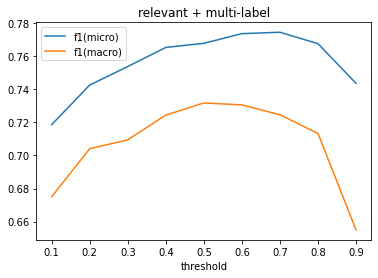

In [126]:
df_select = df[df.type == 'all'][['f1(micro)','f1(macro)']].reset_index(drop=True);
ax = df_select.plot(xticks=df_select.index, title = 'relevant + multi-label', );
ax.set_xticklabels(np.around(Threshold,1));
ax.set_xlabel('threshold');

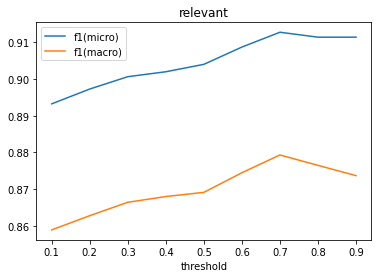

In [128]:
df_select = df[df.type == 'is_relevant'][['f1(micro)','f1(macro)']].reset_index(drop=True)
ax = df_select.plot(xticks=df_select.index, title = 'relevant');
ax.set_xticklabels(np.around(Threshold,1));
ax.set_xlabel('threshold');

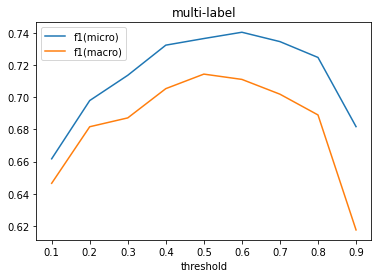

In [129]:
df_select = df[df.type == 'multi'][['f1(micro)','f1(macro)']].reset_index(drop=True)
ax = df_select.plot(xticks=df_select.index, title = 'multi-label');
ax.set_xticklabels(np.around(Threshold,1));
ax.set_xlabel('threshold');

                type  f1(micro)  f1(macro)
0      Armed Assault   0.942915   0.853211
1  Bombing/Explosion   0.967092   0.888545
2         Kidnapping   0.988583   0.823629
3              Other   0.964406   0.825997


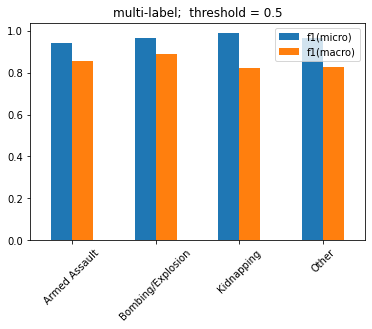

In [119]:
df_select = df[df.type.isin(['Armed Assault','Bombing/Explosion','Kidnapping','Other']) ]
df_select = df_select[df_select.threshold == 0.5][['type','f1(micro)','f1(macro)']]
df_select = df_select.reset_index(drop=True)
print(df_select)
ax = df_select.plot.bar(xticks=df_select.index, title = 'multi-label;  threshold = 0.5', rot= 45);
ax.set_xticklabels(['Armed Assault','Bombing/Explosion','Kidnapping','Other']);

                type  f1(micro)  f1(macro)
0      Armed Assault   0.945601   0.853758
1  Bombing/Explosion   0.969778   0.893562
2         Kidnapping   0.987911   0.801278
3              Other   0.967092   0.820029


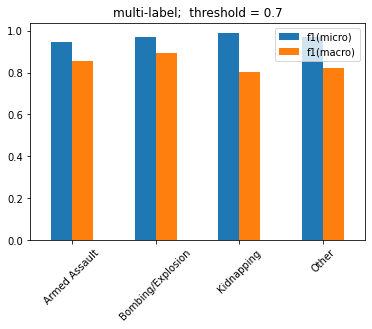

In [120]:
df_select = df[df.type.isin(['Armed Assault','Bombing/Explosion','Kidnapping','Other']) ]
df_select = df_select[df_select.threshold == 0.7][['type','f1(micro)','f1(macro)']]
df_select = df_select.reset_index(drop=True)
print(df_select)
ax = df_select.plot.bar(xticks=df_select.index, title = 'multi-label;  threshold = 0.7', rot= 45);
ax.set_xticklabels(['Armed Assault','Bombing/Explosion','Kidnapping','Other']);